# 6. Wasserstein GAN on MNIST with FC layers

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.1 (29/08/2023)

**Requirements:**
- Python 3 (tested on v3.11.4)
- Matplotlib (tested on v3.7.2)
- Numpy (tested on v1.25.2)
- Torch (tested on v2.0.1+cu118)
- Torchvision (tested on v0.15.2+cu118)
- We also strongly recommend setting up CUDA on your machine! (At this point, honestly, it is almost mandatory).

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch import Tensor
from torch.autograd import Variable
import torch.autograd as autograd
from torchvision.utils import save_image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Dataset and dataloader

As seen many times before...

In [3]:
# Image transform to be applied to dataset
# - Tensor conversion
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# MNIST train dataset
mnist = torchvision.datasets.MNIST(root = './data/',
                                   train = True,
                                   transform = transform,
                                   download = True)

In [5]:
# Data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset = mnist,
                                          batch_size = batch_size, 
                                          shuffle = True)

### Critic model as a set of FC layers

The critic will have roughly the same structure as the Discriminator we had used in Notebook 5.

In [6]:
# Discriminator
class Dicriminator(nn.Module):
    
    def __init__(self, hidden_size, image_size):
        # Init from nn.Module
        super().__init__()
        
        # FC layers
        self.D = nn.Sequential(nn.Linear(image_size, hidden_size),
                               nn.LeakyReLU(0.2),
                               nn.Linear(hidden_size, 1),
                               nn.Sigmoid())
        
    def forward(self, x):
        return self.D(x)

In [7]:
# Critic
class Critic(nn.Module):
    
    def __init__(self, hidden_size, image_size):
        # Init from nn.Module
        super().__init__()
        
        # FC layers
        self.D = nn.Sequential(nn.Linear(image_size, hidden_size),
                               nn.LeakyReLU(0.2, inplace = True),
                               nn.Linear(hidden_size, hidden_size//2),
                               nn.LeakyReLU(0.2, inplace = True),
                               nn.Linear(hidden_size//2, 1))
        
    def forward(self, x):
        return self.D(x)

### Generator model as a set of FC layers

We will make the generator a bit fancier compared to Notebook 5.

In [12]:
# Generator
class Generator(nn.Module):
    
    def __init__(self, latent_size, hidden_size, image_size):
        # Init from nn.Module
        super().__init__()
        
        # FC layers
        self.G = nn.Sequential(nn.Linear(latent_size, hidden_size//4),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(hidden_size//4, hidden_size//2),
                               nn.BatchNorm1d(hidden_size//2, 0.8),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(hidden_size//2, hidden_size),
                               nn.BatchNorm1d(hidden_size, 0.8),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(hidden_size, hidden_size),
                               nn.BatchNorm1d(hidden_size, 0.8),
                               nn.LeakyReLU(0.2, inplace=True),
                               nn.Linear(hidden_size, image_size),
                               nn.Tanh())
        
    def forward(self, x):
        return self.G(x)

### Trainer function

The interleaved training works the same way as in Notebook 5, with one minor change about the loss function, which now comes with a Leipschitz regularization term.

In [13]:
# Hyperparameters for model generation and training
latent_size = 128
hidden_size = 512
image_size = 784
num_epochs = 200
batch_size = 128
n_critic = 5
n_generator = 1

In [14]:
# Create discriminator model
f = Critic(hidden_size, image_size)
f.to(device)

Critic(
  (D): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [15]:
# Create generator model
G = Generator(latent_size, hidden_size, image_size)
G.to(device)

Generator(
  (G): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=512, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [16]:
# Losses and optimizers
d_optimizer = torch.optim.Adam(f.parameters(), lr = 0.00005)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.00005)

In [17]:
# History trackers for training curves
# Keeping track of losses
d_losses = np.zeros(num_epochs)
g_losses = np.zeros(num_epochs)

### Training a GAN is difficult (read me before running)

**Note:** running the cell below (our trainer function) will take a long time!

It is also sensitive to unlucky initialization (as discussed in class).

This basically means that the models are not guaranteed to train well at all, as different values for the initial parameters could lead to two different outcomes for the interleaved training.

This is what makes training a GAN extra difficult!

Feel free to try seeding the models and using different seeds to see how they may converge to different results!

In [18]:
def train(n_critic = 5, n_generator = 1):
    """
    Train the discriminator n_discriminator times in a row,
    then train the generator n_generator times in a row.
    Repeat on all batches for one iteration.
    """
    
    for i, (images, _) in enumerate(data_loader):
        for rep in range(n_critic):
            # 1. Prepare images
            images = images.view(batch_size, -1).to(device)
            images = Variable(images, requires_grad = True)

            # 2. Compute loss for discriminator decisions using real images
            outputs_real = f(images)
            
            # 3. Compute loss for discriminator decisions using fake images
            z = torch.randn(batch_size, latent_size).to(device)
            z = Variable(z)
            fake_images = G(z)
            outputs_fake = f(fake_images)
            
            # 4. Backprop and optimize for f
            # Loss is simply the difference between means
            # Remember to reset gradients for both optimizers!
            d_loss = -torch.mean(outputs_real) + torch.mean(outputs_fake)
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()
            
            # 4.bis. Optional, weight clipping on critic,
            # to prevent gradients from going to crazy values.
            # (Mentioned in WGAN paper)
            clip_val = 0.01
            for p in f.parameters():
                p.data.clamp_(-clip_val, clip_val)

            #  Update the losses and scores for mini-batches
            if rep == n_critic - 1:
                d_losses[epoch] = d_losses[epoch]*(i/(i+1.)) \
                    + d_loss.item()*(1./(i+1.))

            # Print
            if i == 0 or (i+1)%375 == 0:
                print('D - Epoch [{}/{}], Rep [{}/{}], Step [{}/{}], d_loss: {:.9f}' 
                      .format(epoch+1, num_epochs, rep+1, n_critic, i+1, total_step, d_loss.item()))
                
        for rep in range(n_generator):
            
            # 5. Generate fresh noise samples and produce fake images
            z = torch.randn(batch_size, latent_size).to(device)
            real_labels = torch.ones(batch_size, 1).to(device)
            real_labels = Variable(real_labels)
            z = Variable(z)
            fake_images = G(z)
            outputs = f(fake_images)

            # 6. Loss for G
            g_loss = -torch.mean(outputs)

            # 7. Backprop and optimize G
            # Remember to reset gradients for both optimizers!
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            #  Update the losses and scores for mini-batches
            if rep == n_generator - 1:
                g_losses[epoch] = g_losses[epoch]*(i/(i+1.)) \
                + g_loss.item()*(1./(i+1.))

            # Print
            if i == 0 or (i+1)%375 == 0:
                print('G - Epoch [{}/{}], Rep [{}/{}], Step [{}/{}], g_loss: {:.9f}' 
                      .format(epoch+1, num_epochs, rep+1, n_generator, i+1, total_step, g_loss.item()))

In [19]:
def create_images():
    # Generate a few fake samples (6 of them) for visualization
    n_samples = 6
    z = torch.randn(n_samples, latent_size).to(device)
    z = Variable(z)
    fake_images = G(z)
    fake_images = fake_images.cpu().detach().numpy().reshape(n_samples, 28, 28)
    return fake_images

In [20]:
def save_images(epoch = "no_training"):
    # Visualize a few fake samples (6 of them) and save to file
    fake_images = create_images()
    width = 10
    height = 10
    rows = 2
    cols = 3
    axes = []
    fig = plt.figure()
    #print(fake_images[0])
    for i in range(rows*cols):
        axes.append(fig.add_subplot(rows, cols, i+1))
        subplot_title=("Sample" + str(i + 1))
        axes[-1].set_title(subplot_title)  
        plt.imshow(fake_images[i])
    fig.tight_layout()
    plt.savefig('./saved_samples/{}.jpg'.format(epoch))

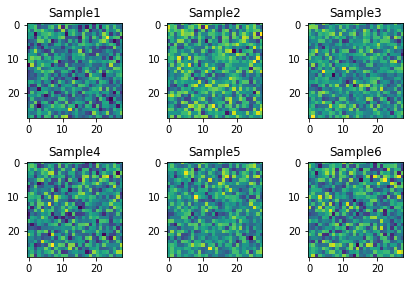

In [21]:
save_images()

----------
Training iteration [1/50] started.
----------
D - Epoch [1/50], Rep [1/5], Step [1/1875], d_loss: 0.031353649
D - Epoch [1/50], Rep [2/5], Step [1/1875], d_loss: 0.000997434
D - Epoch [1/50], Rep [3/5], Step [1/1875], d_loss: -0.000221938
D - Epoch [1/50], Rep [4/5], Step [1/1875], d_loss: -0.001319652
D - Epoch [1/50], Rep [5/5], Step [1/1875], d_loss: -0.002350892
G - Epoch [1/50], Rep [1/1], Step [1/1875], g_loss: 0.010953469
D - Epoch [1/50], Rep [1/5], Step [375/1875], d_loss: -0.351042897
D - Epoch [1/50], Rep [2/5], Step [375/1875], d_loss: -0.359988183
D - Epoch [1/50], Rep [3/5], Step [375/1875], d_loss: -0.390610367
D - Epoch [1/50], Rep [4/5], Step [375/1875], d_loss: -0.356284142
D - Epoch [1/50], Rep [5/5], Step [375/1875], d_loss: -0.375719607
G - Epoch [1/50], Rep [1/1], Step [375/1875], g_loss: 0.440461010
D - Epoch [1/50], Rep [1/5], Step [750/1875], d_loss: -0.494920015
D - Epoch [1/50], Rep [2/5], Step [750/1875], d_loss: -0.633918047
D - Epoch [1/50], Rep

D - Epoch [4/50], Rep [1/5], Step [750/1875], d_loss: -0.496602684
D - Epoch [4/50], Rep [2/5], Step [750/1875], d_loss: -0.490190208
D - Epoch [4/50], Rep [3/5], Step [750/1875], d_loss: -0.493779272
D - Epoch [4/50], Rep [4/5], Step [750/1875], d_loss: -0.562868536
D - Epoch [4/50], Rep [5/5], Step [750/1875], d_loss: -0.511958241
G - Epoch [4/50], Rep [1/1], Step [750/1875], g_loss: 0.163776621
D - Epoch [4/50], Rep [1/5], Step [1125/1875], d_loss: -0.509881973
D - Epoch [4/50], Rep [2/5], Step [1125/1875], d_loss: -0.500113189
D - Epoch [4/50], Rep [3/5], Step [1125/1875], d_loss: -0.520060480
D - Epoch [4/50], Rep [4/5], Step [1125/1875], d_loss: -0.502932906
D - Epoch [4/50], Rep [5/5], Step [1125/1875], d_loss: -0.517722428
G - Epoch [4/50], Rep [1/1], Step [1125/1875], g_loss: -0.054279990
D - Epoch [4/50], Rep [1/5], Step [1500/1875], d_loss: -0.627849698
D - Epoch [4/50], Rep [2/5], Step [1500/1875], d_loss: -0.674681425
D - Epoch [4/50], Rep [3/5], Step [1500/1875], d_loss: 

D - Epoch [7/50], Rep [1/5], Step [1500/1875], d_loss: -0.006961720
D - Epoch [7/50], Rep [2/5], Step [1500/1875], d_loss: -0.010353667
D - Epoch [7/50], Rep [3/5], Step [1500/1875], d_loss: -0.008635541
D - Epoch [7/50], Rep [4/5], Step [1500/1875], d_loss: -0.010159810
D - Epoch [7/50], Rep [5/5], Step [1500/1875], d_loss: -0.009648853
G - Epoch [7/50], Rep [1/1], Step [1500/1875], g_loss: 0.009174943
D - Epoch [7/50], Rep [1/5], Step [1875/1875], d_loss: -0.007422905
D - Epoch [7/50], Rep [2/5], Step [1875/1875], d_loss: -0.006332702
D - Epoch [7/50], Rep [3/5], Step [1875/1875], d_loss: -0.006774663
D - Epoch [7/50], Rep [4/5], Step [1875/1875], d_loss: -0.007984153
D - Epoch [7/50], Rep [5/5], Step [1875/1875], d_loss: -0.007996828
G - Epoch [7/50], Rep [1/1], Step [1875/1875], g_loss: 0.010259690
Training iteration [7/50] completed in 48.2 seconds.
----------
Training iteration [8/50] started.
----------
D - Epoch [8/50], Rep [1/5], Step [1/1875], d_loss: -0.008014312
D - Epoch [

D - Epoch [11/50], Rep [1/5], Step [375/1875], d_loss: -0.550570965
D - Epoch [11/50], Rep [2/5], Step [375/1875], d_loss: -0.635464668
D - Epoch [11/50], Rep [3/5], Step [375/1875], d_loss: -0.549212515
D - Epoch [11/50], Rep [4/5], Step [375/1875], d_loss: -0.585392833
D - Epoch [11/50], Rep [5/5], Step [375/1875], d_loss: -0.632673085
G - Epoch [11/50], Rep [1/1], Step [375/1875], g_loss: 1.566079855
D - Epoch [11/50], Rep [1/5], Step [750/1875], d_loss: -0.070372105
D - Epoch [11/50], Rep [2/5], Step [750/1875], d_loss: 0.087095261
D - Epoch [11/50], Rep [3/5], Step [750/1875], d_loss: 0.301781654
D - Epoch [11/50], Rep [4/5], Step [750/1875], d_loss: 0.120655537
D - Epoch [11/50], Rep [5/5], Step [750/1875], d_loss: -0.008319378
G - Epoch [11/50], Rep [1/1], Step [750/1875], g_loss: -3.562302589
D - Epoch [11/50], Rep [1/5], Step [1125/1875], d_loss: 0.010502815
D - Epoch [11/50], Rep [2/5], Step [1125/1875], d_loss: 0.026423544
D - Epoch [11/50], Rep [3/5], Step [1125/1875], d_lo

D - Epoch [14/50], Rep [1/5], Step [1125/1875], d_loss: -0.000089119
D - Epoch [14/50], Rep [2/5], Step [1125/1875], d_loss: -0.000189645
D - Epoch [14/50], Rep [3/5], Step [1125/1875], d_loss: -0.000133488
D - Epoch [14/50], Rep [4/5], Step [1125/1875], d_loss: -0.000123881
D - Epoch [14/50], Rep [5/5], Step [1125/1875], d_loss: -0.000128414
G - Epoch [14/50], Rep [1/1], Step [1125/1875], g_loss: 0.009752084
D - Epoch [14/50], Rep [1/5], Step [1500/1875], d_loss: -0.168967485
D - Epoch [14/50], Rep [2/5], Step [1500/1875], d_loss: -0.143443704
D - Epoch [14/50], Rep [3/5], Step [1500/1875], d_loss: -0.096212506
D - Epoch [14/50], Rep [4/5], Step [1500/1875], d_loss: -0.158857346
D - Epoch [14/50], Rep [5/5], Step [1500/1875], d_loss: -0.126667738
G - Epoch [14/50], Rep [1/1], Step [1500/1875], g_loss: 1.197381735
D - Epoch [14/50], Rep [1/5], Step [1875/1875], d_loss: -0.115352631
D - Epoch [14/50], Rep [2/5], Step [1875/1875], d_loss: -0.080134153
D - Epoch [14/50], Rep [3/5], Step [

D - Epoch [17/50], Rep [1/5], Step [1875/1875], d_loss: -0.344025254
D - Epoch [17/50], Rep [2/5], Step [1875/1875], d_loss: -0.362890601
D - Epoch [17/50], Rep [3/5], Step [1875/1875], d_loss: -0.395537078
D - Epoch [17/50], Rep [4/5], Step [1875/1875], d_loss: -0.394948363
D - Epoch [17/50], Rep [5/5], Step [1875/1875], d_loss: -0.375034571
G - Epoch [17/50], Rep [1/1], Step [1875/1875], g_loss: -0.947353601
Training iteration [17/50] completed in 50.9 seconds.
----------
Training iteration [18/50] started.
----------
D - Epoch [18/50], Rep [1/5], Step [1/1875], d_loss: -0.332065105
D - Epoch [18/50], Rep [2/5], Step [1/1875], d_loss: -0.314817309
D - Epoch [18/50], Rep [3/5], Step [1/1875], d_loss: -0.342229843
D - Epoch [18/50], Rep [4/5], Step [1/1875], d_loss: -0.307010770
D - Epoch [18/50], Rep [5/5], Step [1/1875], d_loss: -0.334046543
G - Epoch [18/50], Rep [1/1], Step [1/1875], g_loss: -0.949240863
D - Epoch [18/50], Rep [1/5], Step [375/1875], d_loss: -0.015324565
D - Epoch 

D - Epoch [21/50], Rep [1/5], Step [375/1875], d_loss: -0.170482218
D - Epoch [21/50], Rep [2/5], Step [375/1875], d_loss: -0.167738974
D - Epoch [21/50], Rep [3/5], Step [375/1875], d_loss: -0.163310230
D - Epoch [21/50], Rep [4/5], Step [375/1875], d_loss: -0.180749476
D - Epoch [21/50], Rep [5/5], Step [375/1875], d_loss: -0.170463681
G - Epoch [21/50], Rep [1/1], Step [375/1875], g_loss: -0.537944913
D - Epoch [21/50], Rep [1/5], Step [750/1875], d_loss: -0.002126859
D - Epoch [21/50], Rep [2/5], Step [750/1875], d_loss: -0.002735789
D - Epoch [21/50], Rep [3/5], Step [750/1875], d_loss: -0.002364628
D - Epoch [21/50], Rep [4/5], Step [750/1875], d_loss: -0.002329558
D - Epoch [21/50], Rep [5/5], Step [750/1875], d_loss: -0.002548579
G - Epoch [21/50], Rep [1/1], Step [750/1875], g_loss: -0.000712667
D - Epoch [21/50], Rep [1/5], Step [1125/1875], d_loss: 0.002156429
D - Epoch [21/50], Rep [2/5], Step [1125/1875], d_loss: 0.002309961
D - Epoch [21/50], Rep [3/5], Step [1125/1875], 

D - Epoch [24/50], Rep [1/5], Step [1125/1875], d_loss: -0.174512684
D - Epoch [24/50], Rep [2/5], Step [1125/1875], d_loss: -0.264292568
D - Epoch [24/50], Rep [3/5], Step [1125/1875], d_loss: -0.134452730
D - Epoch [24/50], Rep [4/5], Step [1125/1875], d_loss: -0.163857579
D - Epoch [24/50], Rep [5/5], Step [1125/1875], d_loss: -0.150849104
G - Epoch [24/50], Rep [1/1], Step [1125/1875], g_loss: -0.174197376
D - Epoch [24/50], Rep [1/5], Step [1500/1875], d_loss: -0.213734627
D - Epoch [24/50], Rep [2/5], Step [1500/1875], d_loss: -0.280723095
D - Epoch [24/50], Rep [3/5], Step [1500/1875], d_loss: -0.209647283
D - Epoch [24/50], Rep [4/5], Step [1500/1875], d_loss: -0.255713999
D - Epoch [24/50], Rep [5/5], Step [1500/1875], d_loss: -0.300727904
G - Epoch [24/50], Rep [1/1], Step [1500/1875], g_loss: -0.222472101
D - Epoch [24/50], Rep [1/5], Step [1875/1875], d_loss: -0.480237007
D - Epoch [24/50], Rep [2/5], Step [1875/1875], d_loss: -0.455011576
D - Epoch [24/50], Rep [3/5], Step

D - Epoch [27/50], Rep [1/5], Step [1875/1875], d_loss: -0.126465738
D - Epoch [27/50], Rep [2/5], Step [1875/1875], d_loss: -0.120032907
D - Epoch [27/50], Rep [3/5], Step [1875/1875], d_loss: -0.131879240
D - Epoch [27/50], Rep [4/5], Step [1875/1875], d_loss: -0.191433281
D - Epoch [27/50], Rep [5/5], Step [1875/1875], d_loss: -0.157942370
G - Epoch [27/50], Rep [1/1], Step [1875/1875], g_loss: -0.131801546
Training iteration [27/50] completed in 48.4 seconds.
----------
Training iteration [28/50] started.
----------
D - Epoch [28/50], Rep [1/5], Step [1/1875], d_loss: -0.463594377
D - Epoch [28/50], Rep [2/5], Step [1/1875], d_loss: -0.444170952
D - Epoch [28/50], Rep [3/5], Step [1/1875], d_loss: -0.407491237
D - Epoch [28/50], Rep [4/5], Step [1/1875], d_loss: -0.376393080
D - Epoch [28/50], Rep [5/5], Step [1/1875], d_loss: -0.515842319
G - Epoch [28/50], Rep [1/1], Step [1/1875], g_loss: -0.185269535
D - Epoch [28/50], Rep [1/5], Step [375/1875], d_loss: 0.012304723
D - Epoch [

D - Epoch [31/50], Rep [1/5], Step [375/1875], d_loss: -0.256249189
D - Epoch [31/50], Rep [2/5], Step [375/1875], d_loss: -0.236004502
D - Epoch [31/50], Rep [3/5], Step [375/1875], d_loss: -0.240530893
D - Epoch [31/50], Rep [4/5], Step [375/1875], d_loss: -0.312679231
D - Epoch [31/50], Rep [5/5], Step [375/1875], d_loss: -0.265675932
G - Epoch [31/50], Rep [1/1], Step [375/1875], g_loss: -0.139978245
D - Epoch [31/50], Rep [1/5], Step [750/1875], d_loss: -0.245064646
D - Epoch [31/50], Rep [2/5], Step [750/1875], d_loss: -0.216956481
D - Epoch [31/50], Rep [3/5], Step [750/1875], d_loss: -0.286300451
D - Epoch [31/50], Rep [4/5], Step [750/1875], d_loss: -0.198899597
D - Epoch [31/50], Rep [5/5], Step [750/1875], d_loss: -0.247983217
G - Epoch [31/50], Rep [1/1], Step [750/1875], g_loss: -0.249979332
D - Epoch [31/50], Rep [1/5], Step [1125/1875], d_loss: -0.148565888
D - Epoch [31/50], Rep [2/5], Step [1125/1875], d_loss: -0.125940457
D - Epoch [31/50], Rep [3/5], Step [1125/1875]

D - Epoch [34/50], Rep [1/5], Step [1125/1875], d_loss: -0.255232692
D - Epoch [34/50], Rep [2/5], Step [1125/1875], d_loss: -0.256148756
D - Epoch [34/50], Rep [3/5], Step [1125/1875], d_loss: -0.185340703
D - Epoch [34/50], Rep [4/5], Step [1125/1875], d_loss: -0.316230923
D - Epoch [34/50], Rep [5/5], Step [1125/1875], d_loss: -0.266474962
G - Epoch [34/50], Rep [1/1], Step [1125/1875], g_loss: -0.127781063
D - Epoch [34/50], Rep [1/5], Step [1500/1875], d_loss: -0.257509798
D - Epoch [34/50], Rep [2/5], Step [1500/1875], d_loss: -0.269167960
D - Epoch [34/50], Rep [3/5], Step [1500/1875], d_loss: -0.264780909
D - Epoch [34/50], Rep [4/5], Step [1500/1875], d_loss: -0.292651623
D - Epoch [34/50], Rep [5/5], Step [1500/1875], d_loss: -0.265181810
G - Epoch [34/50], Rep [1/1], Step [1500/1875], g_loss: -0.053492516
D - Epoch [34/50], Rep [1/5], Step [1875/1875], d_loss: -0.158370569
D - Epoch [34/50], Rep [2/5], Step [1875/1875], d_loss: -0.141340554
D - Epoch [34/50], Rep [3/5], Step

D - Epoch [37/50], Rep [1/5], Step [1875/1875], d_loss: -0.049927004
D - Epoch [37/50], Rep [2/5], Step [1875/1875], d_loss: -0.050060414
D - Epoch [37/50], Rep [3/5], Step [1875/1875], d_loss: -0.037853502
D - Epoch [37/50], Rep [4/5], Step [1875/1875], d_loss: -0.036147535
D - Epoch [37/50], Rep [5/5], Step [1875/1875], d_loss: -0.056365021
G - Epoch [37/50], Rep [1/1], Step [1875/1875], g_loss: -0.026012484
Training iteration [37/50] completed in 47.5 seconds.
----------
Training iteration [38/50] started.
----------
D - Epoch [38/50], Rep [1/5], Step [1/1875], d_loss: -0.045449786
D - Epoch [38/50], Rep [2/5], Step [1/1875], d_loss: -0.048961647
D - Epoch [38/50], Rep [3/5], Step [1/1875], d_loss: -0.021386631
D - Epoch [38/50], Rep [4/5], Step [1/1875], d_loss: -0.045991033
D - Epoch [38/50], Rep [5/5], Step [1/1875], d_loss: -0.040282756
G - Epoch [38/50], Rep [1/1], Step [1/1875], g_loss: -0.006829296
D - Epoch [38/50], Rep [1/5], Step [375/1875], d_loss: -0.069800459
D - Epoch 

D - Epoch [41/50], Rep [1/5], Step [375/1875], d_loss: -0.181535631
D - Epoch [41/50], Rep [2/5], Step [375/1875], d_loss: -0.093028523
D - Epoch [41/50], Rep [3/5], Step [375/1875], d_loss: -0.111944534
D - Epoch [41/50], Rep [4/5], Step [375/1875], d_loss: -0.074124835
D - Epoch [41/50], Rep [5/5], Step [375/1875], d_loss: -0.146189004
G - Epoch [41/50], Rep [1/1], Step [375/1875], g_loss: 0.045229588
D - Epoch [41/50], Rep [1/5], Step [750/1875], d_loss: -0.029359326
D - Epoch [41/50], Rep [2/5], Step [750/1875], d_loss: -0.016221285
D - Epoch [41/50], Rep [3/5], Step [750/1875], d_loss: -0.024208270
D - Epoch [41/50], Rep [4/5], Step [750/1875], d_loss: -0.033200920
D - Epoch [41/50], Rep [5/5], Step [750/1875], d_loss: -0.033716857
G - Epoch [41/50], Rep [1/1], Step [750/1875], g_loss: 0.130653188
D - Epoch [41/50], Rep [1/5], Step [1125/1875], d_loss: -0.043756872
D - Epoch [41/50], Rep [2/5], Step [1125/1875], d_loss: -0.022283584
D - Epoch [41/50], Rep [3/5], Step [1125/1875], 

D - Epoch [44/50], Rep [1/5], Step [1125/1875], d_loss: -0.042291641
D - Epoch [44/50], Rep [2/5], Step [1125/1875], d_loss: -0.113499820
D - Epoch [44/50], Rep [3/5], Step [1125/1875], d_loss: -0.150232837
D - Epoch [44/50], Rep [4/5], Step [1125/1875], d_loss: -0.127798349
D - Epoch [44/50], Rep [5/5], Step [1125/1875], d_loss: -0.081430048
G - Epoch [44/50], Rep [1/1], Step [1125/1875], g_loss: -0.138696402
D - Epoch [44/50], Rep [1/5], Step [1500/1875], d_loss: -0.091313727
D - Epoch [44/50], Rep [2/5], Step [1500/1875], d_loss: -0.138247564
D - Epoch [44/50], Rep [3/5], Step [1500/1875], d_loss: -0.153421789
D - Epoch [44/50], Rep [4/5], Step [1500/1875], d_loss: -0.162397236
D - Epoch [44/50], Rep [5/5], Step [1500/1875], d_loss: -0.156774729
G - Epoch [44/50], Rep [1/1], Step [1500/1875], g_loss: 0.108730018
D - Epoch [44/50], Rep [1/5], Step [1875/1875], d_loss: -0.054824352
D - Epoch [44/50], Rep [2/5], Step [1875/1875], d_loss: -0.072379529
D - Epoch [44/50], Rep [3/5], Step 

D - Epoch [47/50], Rep [1/5], Step [1875/1875], d_loss: -0.083766133
D - Epoch [47/50], Rep [2/5], Step [1875/1875], d_loss: 0.002969459
D - Epoch [47/50], Rep [3/5], Step [1875/1875], d_loss: -0.059346765
D - Epoch [47/50], Rep [4/5], Step [1875/1875], d_loss: -0.106708236
D - Epoch [47/50], Rep [5/5], Step [1875/1875], d_loss: -0.118210867
G - Epoch [47/50], Rep [1/1], Step [1875/1875], g_loss: -0.110842168
Training iteration [47/50] completed in 48.4 seconds.
----------
Training iteration [48/50] started.
----------
D - Epoch [48/50], Rep [1/5], Step [1/1875], d_loss: -0.330055922
D - Epoch [48/50], Rep [2/5], Step [1/1875], d_loss: -0.346539974
D - Epoch [48/50], Rep [3/5], Step [1/1875], d_loss: -0.370049715
D - Epoch [48/50], Rep [4/5], Step [1/1875], d_loss: -0.343586832
D - Epoch [48/50], Rep [5/5], Step [1/1875], d_loss: -0.349444509
G - Epoch [48/50], Rep [1/1], Step [1/1875], g_loss: -0.127871856
D - Epoch [48/50], Rep [1/5], Step [375/1875], d_loss: -0.271363020
D - Epoch [

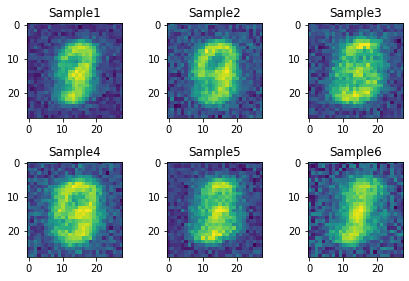

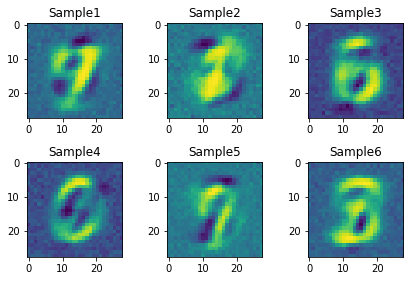

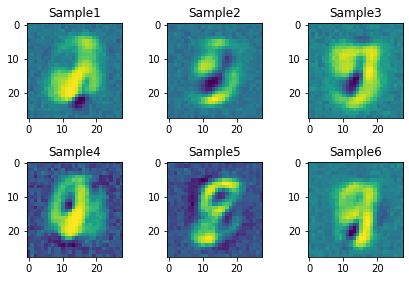

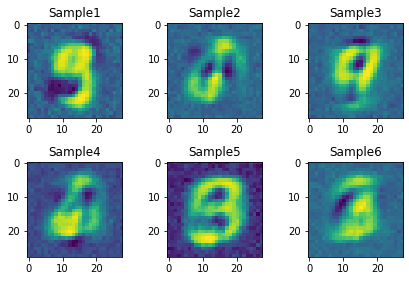

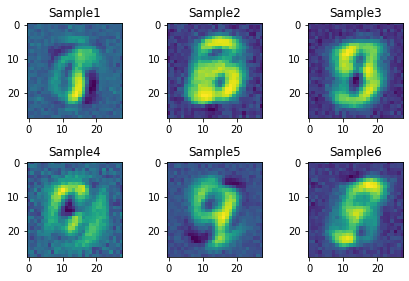

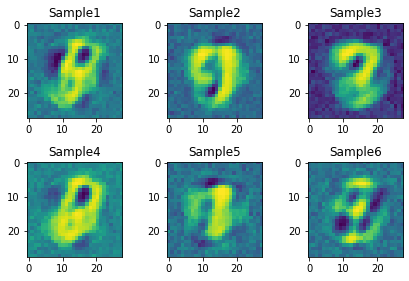

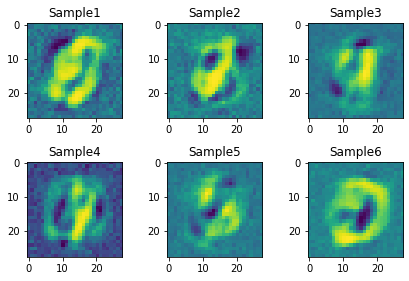

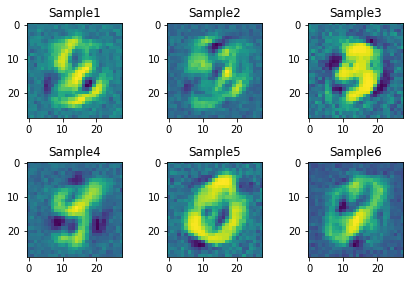

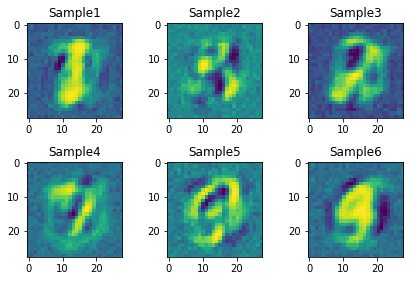

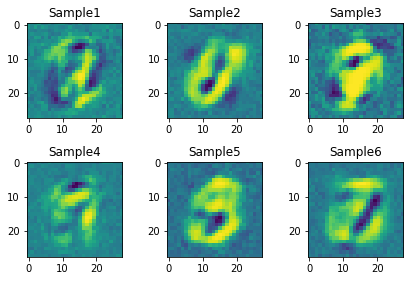

In [22]:
total_step = len(data_loader)
for epoch in range(num_epochs):
    # Print
    print("----------")
    print("Training iteration [{}/{}] started.".format(epoch + 1, num_epochs))
    print("----------")
    
    # Time tracker
    t = time()
    
    # Train for one epoch
    train(n_critic, n_generator)
    
    # Every few iterations, produce some samples and save them
    n_save = 5
    if epoch % n_save == 0:
        save_images(epoch + 1)
        
    # Print time tracker
    t = round(time() - t, 1)
    print("Training iteration [{}/{}] completed in {} seconds.".format(epoch + 1, num_epochs, t))

### Visualization

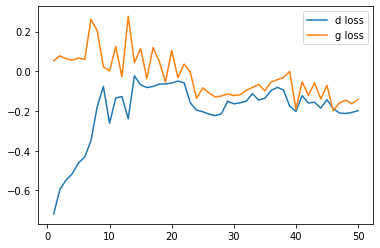

In [23]:
# Display losses for both the generator and discriminator
plt.figure()
plt.plot(range(1, num_epochs + 1), d_losses, label = 'd loss')
plt.plot(range(1, num_epochs + 1), g_losses, label = 'g loss')    
plt.legend()
plt.show()

The Wassestein GANs, while easier to train and capable of better samples, need more cautious control on the training and will usually strongly benefit from additional layers in both the critic and generator.

More control on the initialization and the interleaved training is also needed.

These advanced practices may be discussed in an upcoming homework!

(5, 28, 28)


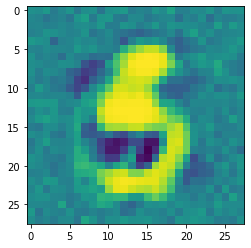

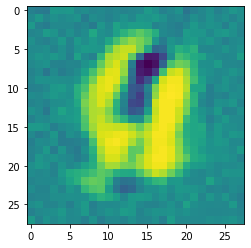

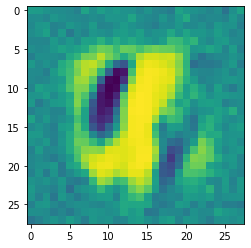

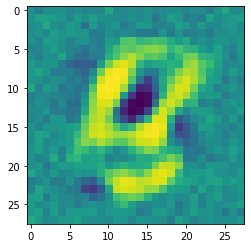

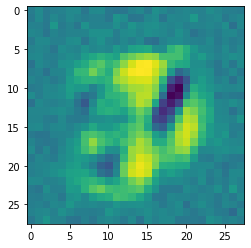

In [24]:
# Generate a fake sample for visualization
n_samples = 5
z = torch.randn(n_samples, latent_size).cuda()
z = Variable(z)
fake_images = G(z)
fake_images = fake_images.cpu().detach().numpy().reshape(n_samples, 28, 28)
print(fake_images.shape)
# Display
plt.figure()
plt.imshow(fake_images[0])
plt.show()
# Display
plt.figure()
plt.imshow(fake_images[1])
plt.show()
# Display
plt.figure()
plt.imshow(fake_images[2])
plt.show()
# Display
plt.figure()
plt.imshow(fake_images[3])
plt.show()
# Display
plt.figure()
plt.imshow(fake_images[4])
plt.show()